SIFT and CNN on the HEp-2 Dataset.

This is a test using 1% of the 63,000 image dataset, which is also randomly chosen from the dataset so it is not just a sequential number of images.  Without SIFT, there is about 634 as expected.  SIFT apparently will discard some of the images.  With SIFT, the number is about 300.  My computer takes about 25 minutes to run this with just 1% of the dataset.  I have save and load code included so it would only have to be run once also, which helps if you want to change other things, so you don't have to preprocess again.  The main time is in the preprocessing.  Training and validation takes under a minute both.

Preprocessing:
- Resizing to 128x128.  Some of them are not this dimension.
- Scaling 0-1 pixel values.
- SIFT, including adding another channel dimension which is required for SIFT.

Loading preprocessed images, labels, and SIFT features from disk.
Loaded preprocessed images, labels, and SIFT features from disk.
Valid images size: 317
Valid labels size: 317
Unique label values after loading from disk: [0 1 2 3 4 5]


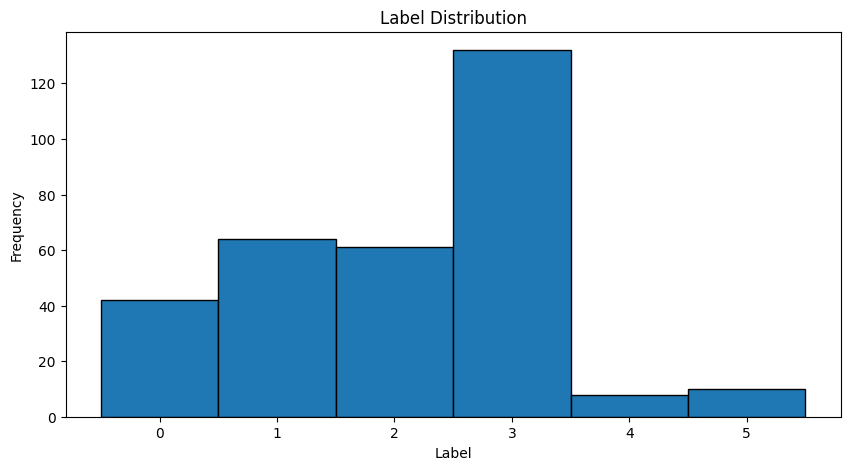

Phase 5: Splitting data into training and validation sets
Phase 5 completed in 0.00 seconds
Unique training labels: [0 1 2 3 4 5]
Unique validation labels: [0 1 2 3 4 5]
Phase 6: Building CNN model
Phase 6 completed in 0.02 seconds
Phase 7: Training CNN model
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.2594 - loss: 1.6584 - val_accuracy: 0.5000 - val_loss: 1.4571
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4648 - loss: 1.3941 - val_accuracy: 0.4375 - val_loss: 1.5586
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.4822 - loss: 1.3968 - val_accuracy: 0.4531 - val_loss: 1.3046
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.6088 - loss: 1.1126 - val_accuracy: 0.5938 - val_loss: 1.1976
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.6598 - loss: 0.9513 - val_accuracy: 0.6094 - val_loss: 1.0979
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.6663 - loss: 0.8428 - val_accuracy: 0.6406 - val_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [6]:
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
import time
import matplotlib.pyplot as plt

if os.path.exists('preprocessed_images.npy') and os.path.exists('valid_labels.npy') and os.path.exists('sift_features.npy'):
    print("Loading preprocessed images, labels, and SIFT features from disk.")
    images = np.load('preprocessed_images.npy')
    valid_labels = np.load('valid_labels.npy')
    sift_features = np.load('sift_features.npy', allow_pickle=True)
    print(f"Loaded preprocessed images, labels, and SIFT features from disk.")
else:
    # Phase 1: Load labels
    print("Phase 1: Loading labels")
    start_time = time.time()
    labels = loadmat('labels.mat')['labels'].flatten()  # Ensure labels are flattened
    print(f"Number of labels: {len(labels)}")
    print(f"Phase 1 completed in {time.time() - start_time:.2f} seconds")
    
    labels = labels - 1

    # Phase 2: Load images
    print("Phase 2: Loading image paths")
    start_time = time.time()
    with open('cells2.txt', 'r') as f:
        image_paths = [line.strip() for line in f.readlines()]
    print(f"Number of image paths: {len(image_paths)}")
    print(f"Phase 2 completed in {time.time() - start_time:.2f} seconds")
   
    assert len(labels) == len(image_paths), "Number of labels does not match number of image paths"

    # Phase 3: Randomly select 1% of data
    print("Phase 3: Randomly selecting 1% of data")
    start_time = time.time()
    sample_size = int(0.01 * len(image_paths))
    sample_indices = random.sample(range(len(image_paths)), sample_size)
    sample_paths = [image_paths[i] for i in sample_indices]
    sample_labels = labels[sample_indices]
    print(f"Sample size: {sample_size}")
    print(f"Sample indices size: {len(sample_indices)}")
    print(f"Sample paths size: {len(sample_paths)}")
    print(f"Sample labels size: {len(sample_labels)}")
    print(f"Phase 3 completed in {time.time() - start_time:.2f} seconds")

    # Phase 4: Preprocessing images
    print("Phase 4: Preprocessing images")
    start_time = time.time()
    sift = cv2.SIFT_create()  # Create SIFT object

    def preprocess_image_and_extract_sift(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Image at path {path} could not be loaded.")
            return None, None
        img_resized = cv2.resize(img, (128, 128))  # Resize to 128x128 pixels
        keypoints, descriptors = sift.detectAndCompute(img_resized, None)  # Extract SIFT features
        img_resized = img_resized / 255.0  # Scaling
        img_resized = np.expand_dims(img_resized, axis=-1)  # Add channel dimension
        return img_resized, descriptors

    images = []
    valid_labels = []
    sift_features = []
    for path, label in zip(sample_paths, sample_labels):
        img, descriptors = preprocess_image_and_extract_sift(path)
        if img is not None and descriptors is not None:
            images.append(img)
            valid_labels.append(label)
            sift_features.append(descriptors)
    
    print(f"Unique label values before saving: {np.unique(valid_labels)}")

    images = np.array(images)
    valid_labels = np.array(valid_labels)
    sift_features = np.array(sift_features, dtype=object)  # Save SIFT features
    np.save('preprocessed_images.npy', images)
    np.save('valid_labels.npy', valid_labels)
    np.save('sift_features.npy', sift_features)
    print("Saved preprocessed images, labels, and SIFT features to disk.")
    print(f"Phase 4 completed in {time.time() - start_time:.2f} seconds")

print(f"Valid images size: {len(images)}")
print(f"Valid labels size: {len(valid_labels)}")

print(f"Unique label values after loading from disk: {np.unique(valid_labels)}")

plt.figure(figsize=(10, 5))
plt.hist(valid_labels, bins=np.arange(7) - 0.5, edgecolor='black')
plt.xticks(range(6))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.show()

if len(images) == 0:
    raise ValueError("No valid images were loaded. Please check the image paths and preprocessing steps.")

# Phase 5: Split data
print("Phase 5: Splitting data into training and validation sets")
start_time = time.time()
X_train, X_val, y_train, y_val = train_test_split(images, valid_labels, test_size=0.2, stratify=valid_labels)
print(f"Phase 5 completed in {time.time() - start_time:.2f} seconds")

print(f"Unique training labels: {np.unique(y_train)}")
print(f"Unique validation labels: {np.unique(y_val)}")

assert np.all(y_train >= 0) and np.all(y_train <= 5), "Training labels contain values outside the range [0, 5]"
assert np.all(y_val >= 0) and np.all(y_val <= 5), "Validation labels contain values outside the range [0, 5]"

# Phase 6: Build CNN Model
print("Phase 6: Building CNN model")
start_time = time.time()
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  # 6 classes
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(f"Phase 6 completed in {time.time() - start_time:.2f} seconds")

# 7. Train model
print("Phase 7: Training CNN model")
start_time = time.time()
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
print(f"Phase 7 completed in {time.time() - start_time:.2f} seconds")

# 8. Evaluate model
print("Phase 8: Evaluating model")
start_time = time.time()
metrics = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {metrics[1]}")
print(f"Phase 8 completed in {time.time() - start_time:.2f} seconds")

# Compute and print classification metrics
y_pred = np.argmax(model.predict(X_val), axis=1)
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=[str(i) for i in range(6)]))
